# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 2 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0

https://drive.google.com/open?id=1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW4')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)
image_save_path = os.path.join(HOMEWORK_FOLDER, 'DCGAN_images')
checkpoint_path = os.path.join(HOMEWORK_FOLDER, 'DCGAN_checkpoints')

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1ABUtpgdWMnMG6S6wLgqxXnAQ-8Fyq5F0': 'test.npz',
'1ilx871Zws-rS1Ek_ZAC-imD50A8bTQ80': 'train.npz',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


In [0]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data.dataloader as Dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VAE

## Prepare Dataset

In [0]:

bs = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:04, 2360999.34it/s]                             


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57386.31it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


1654784it [00:01, 968701.82it/s]                             
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


8192it [00:00, 21704.69it/s]            

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


## Model Definition

In [0]:
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2a = nn.Linear(400, 20)
        self.fc2b = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2a(h1), self.fc2b(h1)

    def reparameterize(self, mu, logvar):
        '''
        z = mu + eps * sigma
        eps ~ N(0, 1)
        '''
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)    # [20, ]

    def decode(self, z):
        h3 = F.relu(self.fc3(z))        # [400, ]
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
        

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
vae

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2a): Linear(in_features=400, out_features=20, bias=True)
  (fc2b): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

## Loss Function

In [0]:
def loss_function(recon_x, x, mu, logvar):
    '''
    Reconstruction + KL divergence losses summed over all elements and batch
    '''
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

## Train

In [0]:
def train(epoch, train_losses):
    vae.train()
    train_loss = 0
    step = 100
    for i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item() / (len(data))
        optimizer.step()

        if i % step == 0:
           print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Average loss: {:.4f}'.format(epoch, 
                                50, i+1, len(train_loader), loss.item() / (len(data)), train_loss / (i+1)))
           
        train_losses.append(loss.item() / (len(data)))

## Test

In [0]:
def test(test_losses):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            loss = loss_function(recon, data, mu, log_var)
            test_loss += loss.item() / (len(data))
               
            test_losses.append(loss.item() / (len(data)))  

    test_loss /= len(test_loader.dataset)
    print ('Test Loss: {:.4f}, Average loss: {:.4f}'.format(loss.item() / (len(data)), test_loss))

## Visualization

In [0]:
def plot_grid(images, epoch):
    '''
    images: [batch_size, 28, 28, 1]
    '''
    size = 6
    fig = plt.figure(epoch, figsize=(8,8))
    for i in range(1, size*size+1):
        ax = fig.add_subplot(size,size,i)
        ax.imshow(images[i - 1])
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


Epoch [1/50], Step [1/469], Loss: 546.9083, Average loss: 546.9083
Epoch [1/50], Step [101/469], Loss: 184.9921, Average loss: 233.0980
Epoch [1/50], Step [201/469], Loss: 158.0605, Average loss: 198.8426
Epoch [1/50], Step [301/469], Loss: 136.2445, Average loss: 181.4302
Epoch [1/50], Step [401/469], Loss: 130.5865, Average loss: 170.0331
Test Loss: 118.5262, Average loss: 1.0035
Epoch [2/50], Step [1/469], Loss: 132.7833, Average loss: 132.7833
Epoch [2/50], Step [101/469], Loss: 122.3456, Average loss: 126.6407
Epoch [2/50], Step [201/469], Loss: 122.8701, Average loss: 124.7626
Epoch [2/50], Step [301/469], Loss: 122.2805, Average loss: 123.2881
Epoch [2/50], Step [401/469], Loss: 120.3732, Average loss: 122.2448
Test Loss: 108.7585, Average loss: 0.9155
Epoch [3/50], Step [1/469], Loss: 109.7516, Average loss: 109.7516
Epoch [3/50], Step [101/469], Loss: 121.6543, Average loss: 116.2021
Epoch [3/50], Step [201/469], Loss: 118.1668, Average loss: 115.7335
Epoch [3/50], Step [301/4

Text(0.5, 1.0, 'test loss - iteration')

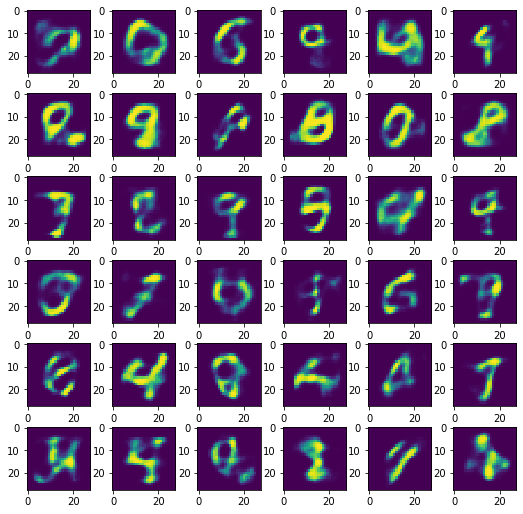

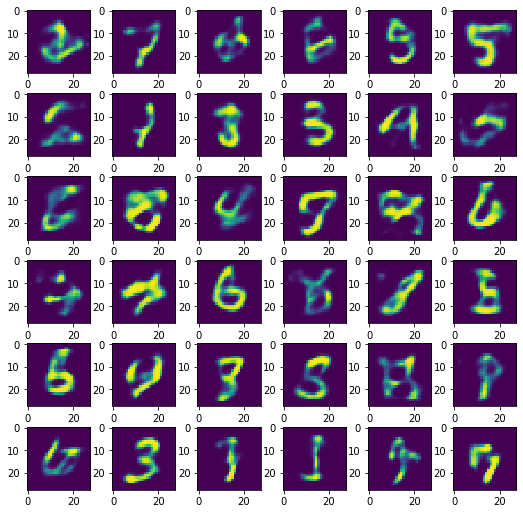

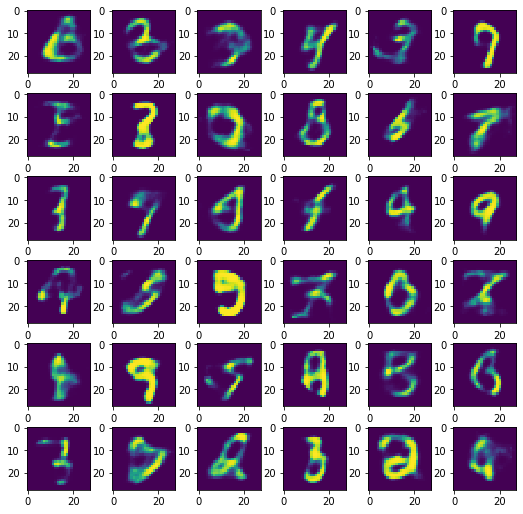

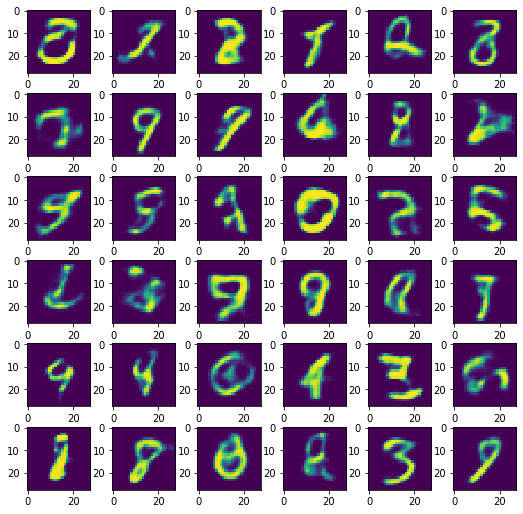

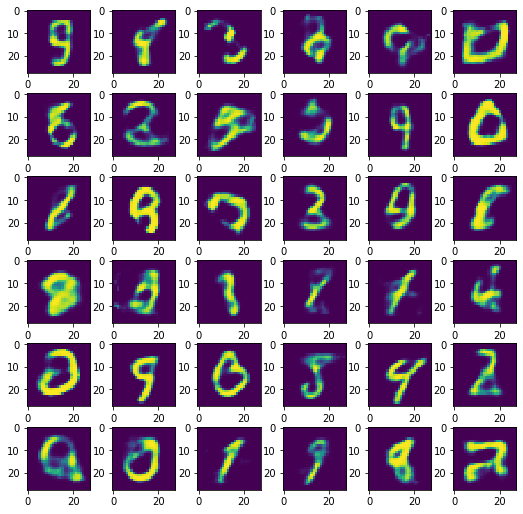

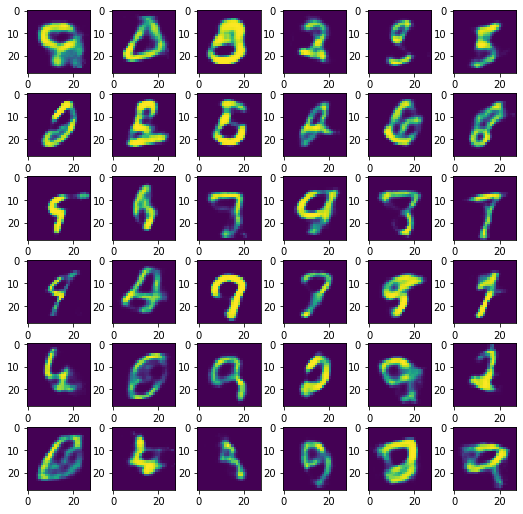

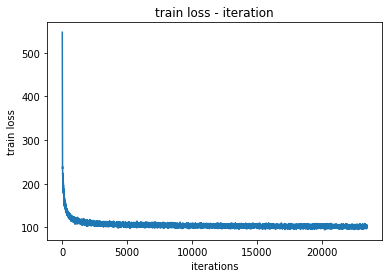

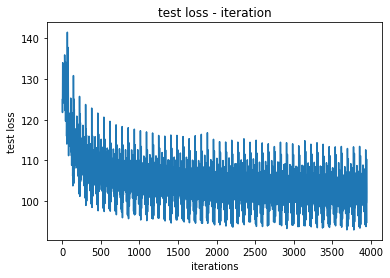

In [0]:
train_losses, test_losses = [], []
plot_iter = [5, 15, 25, 35, 45, 50]

for epoch in range(1, 51):
    train(epoch, train_losses)
    test(test_losses)

    # Show 36 generated images on the run
    with torch.no_grad():
        if epoch in plot_iter:
            sample = torch.randn(36, 20).to(device)
            sample = vae.decode(sample).cpu()           # [36, 784]
            images = sample.view(36, 28, 28).numpy()
            plot_grid(images, epoch)
            
# Plot training and testing loss curves
plt.figure(1)
plt.plot(np.arange(len(train_losses)), train_losses)
plt.xlabel("iterations")
plt.ylabel("train loss")
plt.title("train loss - iteration")

plt.figure(2)
plt.plot(np.arange(len(test_losses)), test_losses)
plt.xlabel("iterations")
plt.ylabel("test loss")
plt.title("test loss - iteration")     


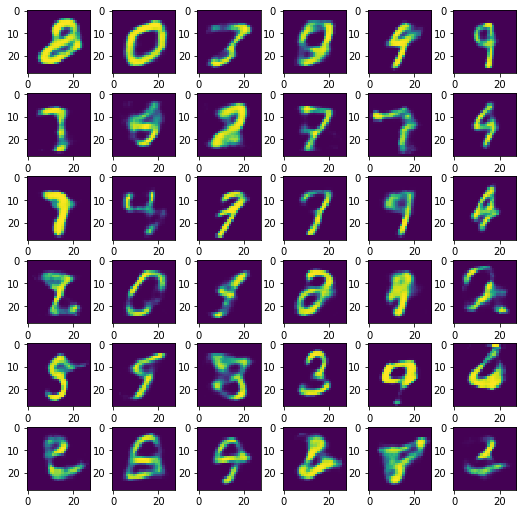

In [0]:
# Show 36 generated images after training
with torch.no_grad():
    sample_data = torch.randn(36, 20).to(device)
    sample_data = vae.decode(sample_data).cpu()           # [36, 784]
    images = sample_data.view(36, 28, 28).numpy()
    plot_grid(images, epoch)

# DCGAN

## Prepare Dataset

In [0]:
from torchvision.datasets import STL10

def load_data(batch_size=128, download=False):
    '''
    return:
        train_set: [5000, [3, 64, 64] + label(0~9)]
        test_set: [8000, [3, 64, 64] + label(0~9)]
    '''
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_set = STL10(root=HOMEWORK_FOLDER, split='train', download=download, transform=transform)
    test_set = STL10(root=HOMEWORK_FOLDER, split='test', download=download, transform=transform)

    return train_set + test_set

def random_imshow(dataset, plot_num = 8):
    '''
    randomly show some resized images
    '''
    img_num = np.random.choice(len(dataset), plot_num)
    fig = plt.figure()
    
    for i in range(1, plot_num+1):
        ax = fig.add_subplot(2,4,i)
        image = dataset[img_num[i-1]][0].numpy().transpose(1,2,0)
        ax.imshow(image)
    

num_batches = 128
dataset = load_data()               # dataset: [13000, ([3, 64, 64], label) ]
random_imshow(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_batches, shuffle=True)

NameError: ignored

## Model Definition

In [0]:
def weights_init(m):
    '''
    custom weights initialization called on netG and netD
    '''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        print(m.weight.shape)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# G(z)
class Generator(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, z_size=100, out_size=3, ngf=128):
        super(Generator, self).__init__()
        self.z_size = z_size        # latent vector size
        self.ngf = ngf              
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            # state size: ngf x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: out_size x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

netG = Generator().to(device)
netG.apply(weights_init)
print(netG)


class Discriminator(nn.Module):
    '''
        Discriminative Network
    '''
    def __init__(self, in_size=3, ndf=128):
        super(Discriminator, self).__init__()
        self.in_size = in_size
        self.ndf = ndf

        self.main = nn.Sequential(
            # input size is in_size x 64 x 64
            nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: ndf x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 8) x 4 x 4
            nn.Conv2d(self.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size: 1 x 1 x 1
        )

    def forward(self, input):
        output = self.main(input)
        return output

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

torch.Size([100, 1024, 4, 4])
torch.Size([1024, 512, 4, 4])
torch.Size([512, 256, 4, 4])
torch.Size([256, 128, 4, 4])
torch.Size([128, 3, 4, 4])
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

## Train

In [0]:
num_epochs = 200
print_step = 20
batch_size = 128

# image show steps
save_epoch = [2, 20, 40, 80, 160, 199]

# loss function
criterion = nn.BCELoss()
loss_d_lst = []
loss_g_lst = []

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
dim_z = 100
fixed_noise = torch.randn(batch_size, dim_z, 1, 1, device=device)
real_label = 1
fake_label = 0


for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        # train with real data
        optimizerD.zero_grad()
        real_img = data[0].to(device)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_img).squeeze()
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake data
        noise = torch.randn(batch_size, dim_z, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).squeeze()
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update Generator: maximize log(D(G(z)))
        ############################
        optimizerG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).squeeze()
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % print_step == 0:
            print('[%d/%d][%d/%d] Loss_D: %.6f Loss_G: %.6f '
                % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item()))
        
        loss_d_lst.append(errD.item())
        loss_g_lst.append(errG.item())

    if epoch in save_epoch:
        real_img_show = real_img[0:36]
        save_image(real_img_show,'%s/real_samples_epoch_%03d.png' 
                   % (image_save_path, epoch), nrow=6, padding=4, normalize=True)
        fake = netG(fixed_noise)
        fake_show = fake[0:36]
        save_image(fake_show.detach(), '%s/fake_samples_epoch_%03d.png' 
                   % (image_save_path, epoch), nrow=6, padding=4, normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (checkpoint_path, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (checkpoint_path, epoch))

[0/200][0/102] Loss_D: 2.073267 Loss_G: 3.734237 
[0/200][20/102] Loss_D: 0.005315 Loss_G: 36.920502 
[0/200][40/102] Loss_D: 0.002127 Loss_G: 53.279808 
[0/200][60/102] Loss_D: 0.000507 Loss_G: 53.196175 
[0/200][80/102] Loss_D: 0.000315 Loss_G: 53.169861 
[0/200][100/102] Loss_D: 0.000821 Loss_G: 52.447334 
[1/200][0/102] Loss_D: 0.000966 Loss_G: 53.058529 
[1/200][20/102] Loss_D: 0.000147 Loss_G: 53.027485 
[1/200][40/102] Loss_D: 0.000062 Loss_G: 52.887939 
[1/200][60/102] Loss_D: 0.000095 Loss_G: 52.237442 
[1/200][80/102] Loss_D: 0.000608 Loss_G: 52.701218 
[1/200][100/102] Loss_D: 0.000084 Loss_G: 52.727669 
[2/200][0/102] Loss_D: 0.000124 Loss_G: 52.559654 
[2/200][20/102] Loss_D: 0.000049 Loss_G: 52.405396 
[2/200][40/102] Loss_D: 0.000053 Loss_G: 52.333309 
[2/200][60/102] Loss_D: 0.000065 Loss_G: 52.221905 
[2/200][80/102] Loss_D: 0.000226 Loss_G: 52.631783 
[2/200][100/102] Loss_D: 0.000148 Loss_G: 52.668667 
[3/200][0/102] Loss_D: 0.000056 Loss_G: 52.180611 
[3/200][20/102

## Visualization

Text(0.5, 1.0, 'Generator loss - Updates')

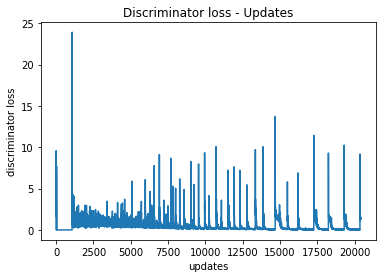

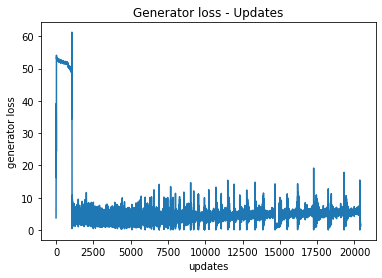

In [0]:
# Plot training loss curves
plt.figure(1)
plt.plot(np.arange(len(loss_d_lst)), loss_d_lst)
plt.xlabel("updates")
plt.ylabel("discriminator loss")
plt.title("Discriminator loss - Updates")

plt.figure(2)
plt.plot(np.arange(len(loss_g_lst)), loss_g_lst)
plt.xlabel("updates")
plt.ylabel("generator loss")
plt.title("Generator loss - Updates")     

# Super-Resolution 


## Prepare LR, HR dataset

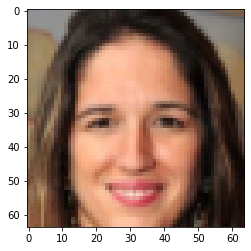

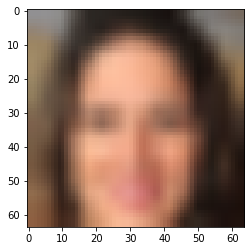

In [0]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self):

        self.train_set = np.load("train.npz")['arr_0'].astype(np.uint8)      # [20000, 64, 64, 3]

        # Low resolution transformed dataset
        self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(16),
                transforms.Resize(64)
                ])

    def __len__(self):
        return self.trainset.shape[0]


    def __getitem__(self, index):
        # low-resolution dataset
        lr = torch.from_numpy(np.array(self.transform(self.train_set[index])))

        # high-resolution dataset
        hr = torch.from_numpy(self.train_set[index])
        
        return hr,lr              # torch.tensor([21000, 64, 64, 3], dtype=torch.uint8)

train_set = Dataset()
test_set = np.load("test.npz")['arr_0'].astype(np.uint8)        # [1000, 64, 64, 3]

# Test low resolution dataset
plt.figure(1)
plt.imshow(train_set[0][0])
plt.figure(2)
plt.imshow(train_set[0][1])
plt.show()

## Model Definition

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ###########
        # Encoder #
        ###########
        # 1
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # 2
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        # 3
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        # 4
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        # 5
        self.conv5 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=512)

        #############################
        # Decoder + skip connection #
        #############################
        # 1 + conv5
        self.deconv1 = nn.ConvTranspose2d(512+512, 256, 4, stride=2, padding=1)
        self.debn1 = nn.BatchNorm2d(num_features=256)
        # 2 + conv4
        self.deconv2 = nn.ConvTranspose2d(256+256, 128, 4, stride=2, padding=1)
        self.debn2 = nn.BatchNorm2d(num_features=128)
        # 3 + conv3
        self.deconv3 = nn.ConvTranspose2d(128+128, 64, 4, stride=2, padding=1)
        self.debn3 = nn.BatchNorm2d(num_features=64)
        # 4 + conv2
        self.deconv4 = nn.ConvTranspose2d(64+64, 32, 4, stride=2, padding=1)
        self.debn4 = nn.BatchNorm2d(num_features=32)
        # 5 + conv1
        self.deconv5 = nn.ConvTranspose2d(32+32, 16, 4, stride=2, padding=1)
        self.debn5 = nn.BatchNorm2d(num_features=16)
        # 6 + image
        self.deconv6 = nn.ConvTranspose2d(16+3, 3, 3, padding=1)

        

    def forward(self, x):
        ###########
        # Encoder #
        ###########
        # 1
        img = x
        x1 = F.leaky_relu(self.bn1(self.conv1(img)))
        # 2
        x2 = F.leaky_relu(self.bn2(self.conv2(x1)))
        # 3
        x3 = F.leaky_relu(self.bn3(self.conv3(x2)))
        # 4
        x4 = F.leaky_relu(self.bn4(self.conv4(x3)))
        # 5
        x5 = F.leaky_relu(self.bn5(self.conv5(x4)))

        ###########
        # Decoder #
        ###########
        # 1
        x = torch.cat((x5, x5), dim=1)
        x = F.leaky_relu(self.debn1(self.deconv1(x)))
        # 2
        x = torch.cat((x, x4), dim=1)
        x = F.leaky_relu(self.debn2(self.deconv2(x)))
        # 3
        x = torch.cat((x, x3), dim=1)
        x = F.leaky_relu(self.debn3(self.deconv3(x)))
        # 4 + conv2
        x = torch.cat((x, x2), dim=1)
        x = F.leaky_relu(self.debn4(self.deconv4(x)))
        # 5 + conv1
        x = torch.cat((x, x1), dim=1)
        x = F.leaky_relu(self.debn5(self.deconv5(x)))
        # 6 + image
        x = torch.cat((x, img), dim=1)
        x = torch.tanh(self.deconv6(x))

        return x

net_G = Generator().to(device)
img = dataset[0][0].permute(2, 0, 1).unsqueeze(0).to(device, dtype=torch.float)
out = net_G(img)
print(out.shape)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1, 3, stride=2, padding=1)

        
    def forward(self, x):

        # 1
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        # 2
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        # 3
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        # 4
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        # 5
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        #6
        x = F.sigmoid(self.conv6(x))
        return x



torch.Size([1, 3, 64, 64])


## Loss Function

In [0]:
class PerceptualLoss(torch.nn.Module):
  def __init__(self, model='net-lin',net='alex'):
    super(PerceptualLoss, self).__init__()
    self.model = 


## Train

In [0]:
num_batches = 32
num_epochs = 100

train_loader = DataLoader(train_set, batch_size=num_batches, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# image show steps
save_epoch = [2, 20, 40, 80, 160, 199]

# loss function
criterion = nn.BCELoss()
loss_d_lst = []
loss_g_lst = []

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        pass

## Visualization

In [0]:
# Compute LPIPS:

# compute LPISP:
# import argparse
# import models
# from util import util
# import csv
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import pylab
# import cv2


# # Read CSV & output images:

# data_gen = pd.read_csv('./gen_img_list.csv')
# data_hr = pd.read_csv('./hr_img_list.csv')

# # img_gen = data_gen.values[0]
# # img_hr = data_hr.values[0]

# # img_gen = img_gen.reshape(64,64,3)
# # # img_gen = np.transpose(img_gen,(2,1,0))

# # img_hr = img_hr.reshape(64,64,3)
# # # img_hr = np.transpose(img_hr, (2,1,0))

# # plt.imshow(img_gen)
# # plt.imshow(img_hr)
# # pylab.show()


# # for i in range(999):
# #     img_gen = data_gen.values[i]
# #     # img_hr = data_hr.values[i]

# #     img_gen = img_gen.reshape(64,64,3)

# #     fig1 = plt.gcf()

# #     plt.imshow(img_gen)
# #     fig1.savefig("./IMG_GEN/gen_%d.jpg"%i)
# #     # fig2.savefig("./IMG_HR/hr_%d.jpg"%i)




# # for i in range(999):
# #     # img_gen = data_gen.values[i]
# #     img_hr = data_hr.values[i]

# #     img_hr = img_hr.reshape(64,64,3)
# #     # img_hr = np.transpose(img_hr, (2,1,0))
# #     fig2 = plt.gcf()

# #     plt.imshow(img_hr)
# #     fig2.savefig("./IMG_HR/hr_%d.jpg"%i)
# #     # fig2.savefig("./IMG_HR/hr_%d.jpg"%i)

# lpisp_val = 0.0
# lpisp_val_list = []

# for i in range(999):

#     parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
#     parser.add_argument('-p0','--path0', type=str, default='./IMG_HR/hr_%d.jpg'%i) # hr
#     parser.add_argument('-p1','--path1', type=str, default='./IMG_GEN/gen_%d.jpg'%i) # gen
#     parser.add_argument('--use_gpu', action='store_true', help='turn on flag to use GPU')

#     opt = parser.parse_args()

#     ## Initializing the model
#     model = models.PerceptualLoss(model='net-lin',net='alex',use_gpu=opt.use_gpu)

#     img0 = util.im2tensor(util.load_image(opt.path0)) # RGB image from [-1,1]
#     img1 = util.im2tensor(util.load_image(opt.path1))

#     lpisp_val = model.forward(img0,img1)
#     if i % 10 == 0:
#         print("img: {} finished:".format(i))

#     lpisp_val_list.append(lpisp_val)
#     if i == 998:
#         print("Finished")

# # print("LPIPS VALUE: {}".format(lpisp_val_list))
# print("Len of list: {}".format(len(lpisp_val_list)))
# avg_lpisp = sum(lpisp_val_list) / 999
# print("LPIPS VALUE: {}".format(avg_lpisp))